In [ ]:
!pip install umap-learn biopython transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

### **Data Preprocessing**:
*   Download sequences in FASTA format
*   Filter to get 200-500 sequences with binary labels (e.g., resistant vs. non-resistant)
*   Clean sequences (remove ambiguous nucleotides, standardize length if necessary)
*   Split data into classes based on labels

In [ ]:
def normalize_id(id_str):
    if '.' in id_str:
        left, right = id_str.split('.')
        return f"{left}.{right.ljust(5, '0')}"
    return id_str

In [ ]:
from Bio import SeqIO
import pandas as pd
import numpy as np


# Step 1: Parse FASTA file and collect sequences with their IDs
fasta_records = []
for record in SeqIO.parse("pbp4_1.fasta", "fasta"): #labels_1.txt
    fasta_records.append({
        'id': record.id,  # Extracts the unique ID like 1280.113
        'sequence': str(record.seq)
    })

for record in SeqIO.parse("pbp4_2.fasta", "fasta"): #labels_2.txt
    fasta_records.append({
        'id': record.id,  # Extracts the unique ID like 1280.113
        'sequence': str(record.seq)
    })

for record in SeqIO.parse("gyrA.fasta", "fasta"): #labels_gyrA.txt
    fasta_records.append({
        'id': record.id,  # Extracts the unique ID like 1280.113
        'sequence': str(record.seq)
    })

for record in SeqIO.parse("gyrA_2.fasta", "fasta"): #labels_gyrA_2.txt
    fasta_records.append({
        'id': record.id,  # Extracts the unique ID like 1280.113
        'sequence': str(record.seq)
    })


fasta_df = pd.DataFrame(fasta_records)

fasta_df['id'] = fasta_df['id'].astype(str).apply(normalize_id)

print("Shape of fasta_df: ", fasta_df.shape)

# Step 2: Load labels file (Two columns: id and label)
# labels_df = pd.read_csv("labels_1.txt", sep='\t', engine='python', header=None, names=['id', 'label'])

labels_df = pd.concat([
    pd.read_csv("labels_1.txt", sep='\t', engine='python', header=None, names=['id', 'label']),
    pd.read_csv("labels_2.txt", sep='\t', engine='python', header=None, names=['id', 'label']),
    pd.read_csv("labels_gyrA.txt", sep='\t', engine='python', header=None, names=['id', 'label']),
    pd.read_csv("labels_gyrA_2.txt", sep='\t', engine='python', header=None, names=['id', 'label'])
], axis=0, ignore_index=True)

labels_df['id'] = labels_df['id'].astype(str).apply(normalize_id)

print("Shape of labels_df: ", labels_df.shape)

# # --- Added for debugging ---
# print("First 5 IDs in fasta_df:")
# print(fasta_df['id'].head())
# print("\nFirst 5 IDs in labels_df:")
# print(labels_df['id'].head())
# print("-" * 20)
# # --- End of debugging additions ---

# Step 3: Merge the sequences with labels on ID
merged_df = pd.merge(fasta_df, labels_df, on='id')

# --- Added for debugging ---
print(f"Number of rows in merged_df after initial merge: {len(merged_df)}")
# --- End of debugging additions ---

# print("Shape after merging: ", merged_df.shape)

# Step 4: Remove sequences with ambiguous nucleotides
merged_df['sequence'] = merged_df['sequence'].str.upper()
merged_df = merged_df[~merged_df['sequence'].str.contains('[^ATGC]')]

# print("Shape after merging: ", merged_df.shape)

merged_df.to_csv('processed_sequences.csv', index=False)

# Step 5: Balance the classes if needed
min_class_size = min(merged_df['label'].value_counts())
data_bal = pd.concat([
    merged_df[merged_df['label'] == 0].sample(min_class_size, random_state=42),
    merged_df[merged_df['label'] == 1].sample(min_class_size, random_state=42)
])

# Step 6: Save processed data
data_bal.to_csv('processed_sequences.csv', index=False)

Shape of fasta_df:  (300, 2)
Shape of labels_df:  (300, 2)
Number of rows in merged_df after initial merge: 300


In [ ]:
data_bal.shape
min_class_size = min(data_bal['label'].value_counts())
data_bal['label'].value_counts()

# merged_df.shape
# min_class_size = min(merged_df['label'].value_counts())
# merged_df['label'].value_counts()

,count
label,
0,55
1,55


### **Generate DNABERT Embeddings**

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd

# Load tokenizer and model
model_name = "zhihan1996/DNA_bert_6"  # For 6-mer DNABERT
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Function to convert DNA sequence to k-mers
def seq_to_kmers(seq, k=6):
    kmers = []
    for i in range(len(seq) - k + 1):
        kmers.append(seq[i:i+k])
    return " ".join(kmers)

# Load your sequences
data = pd.read_csv('processed_sequences.csv')

# Convert to k-mers and generate embeddings
embeddings = []
labels = []

for idx, row in data.iterrows():
    seq = row['sequence']
    label = row['label']

    # Convert to k-mers
    kmer_seq = seq_to_kmers(seq)

    # Tokenize and get embeddings
    inputs = tokenizer(kmer_seq, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Get CLS token embedding (first token)
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy().flatten()

    embeddings.append(cls_embedding)
    labels.append(label)

# Save embeddings
embedding_df = pd.DataFrame(embeddings)
embedding_df['label'] = labels
embedding_df.to_csv('dnabert_embeddings.csv', index=False)

### **Dimensionality Reduction and Visualization**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


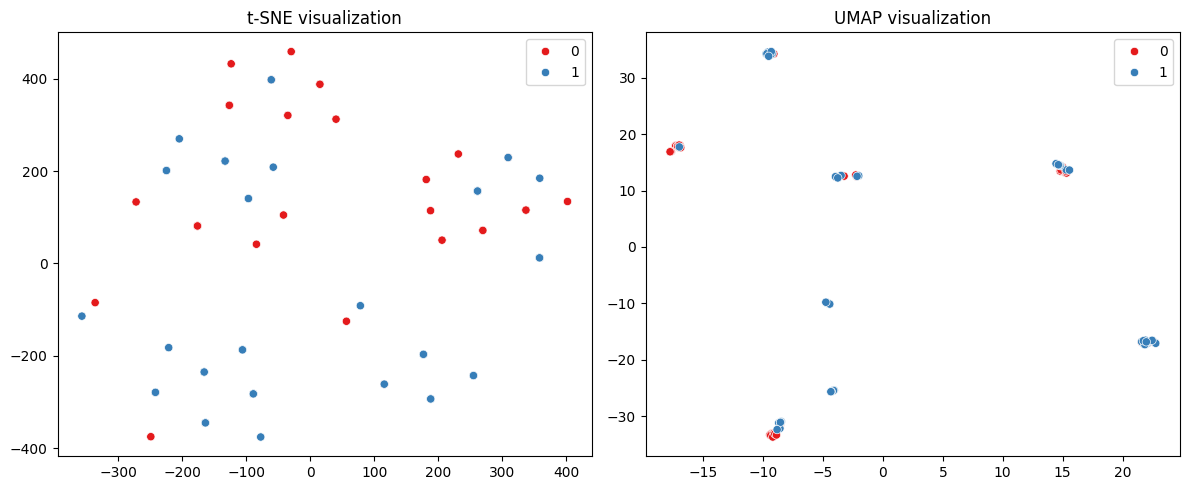

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Load embeddings
embedding_df = pd.read_csv('dnabert_embeddings.csv')
X = embedding_df.drop('label', axis=1).values
y = embedding_df['label'].values

# PCA for initial dimensionality reduction
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(X_pca)
pca_df.columns = [f'PC{i+1}' for i in range(pca_df.shape[1])]
pca_df.to_csv('pca_embeddings.csv', index=False)

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# UMAP for visualization (alternative)
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

umap_df = pd.DataFrame(X_umap)
# umap_df.columns = [f'PC{i+1}' for i in range(pca_df.shape[1])]
umap_df.to_csv('umap_embeddings.csv', index=False)

# Visualize
plt.figure(figsize=(12, 5))

# t-SNE plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set1')
plt.title('t-SNE visualization')

# UMAP plot
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='Set1')
plt.title('UMAP visualization')

plt.tight_layout()
plt.savefig('embedding_visualization.png')
plt.show()

### **Outlier Detection**

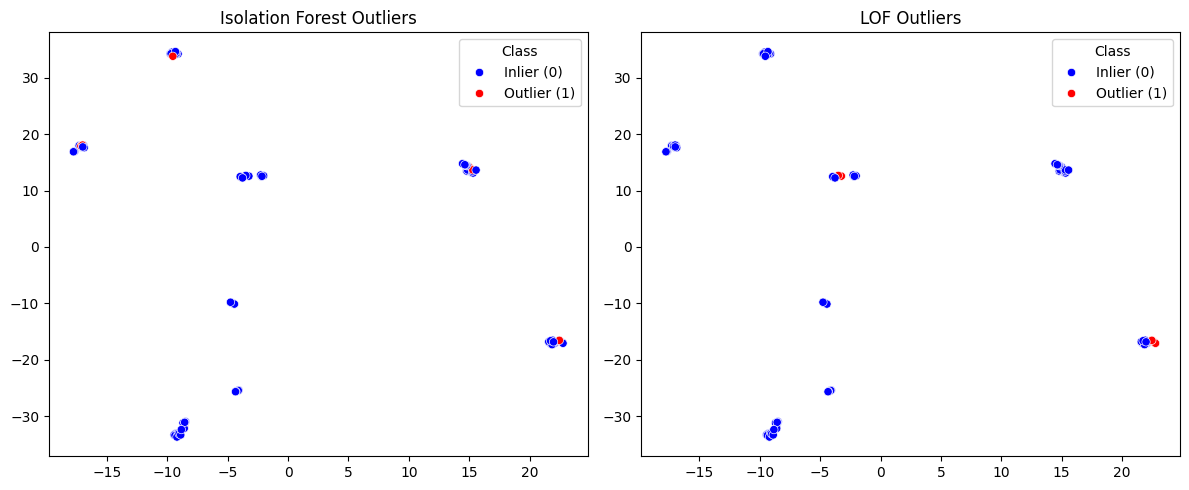

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import matplotlib.pyplot as plt

# Load dimensionality-reduced embeddings
X_pca = pd.read_csv('pca_embeddings.csv').values
labels = pd.read_csv('dnabert_embeddings.csv')['label'].values

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.10, random_state=42)
outliers_if = iso_forest.fit_predict(X_pca)
# Convert to binary (1: inlier, -1: outlier)
outliers_if = [1 if x == -1 else 0 for x in outliers_if]

# Apply Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.10)
outliers_lof = lof.fit_predict(X_pca)
# Convert to binary (1: inlier, -1: outlier)
outliers_lof = [1 if x == -1 else 0 for x in outliers_lof]

# Create DataFrame with results
results = pd.DataFrame({
    'sequence_id': range(len(X_pca)),
    'true_label': labels,
    'isolation_forest_outlier': outliers_if,
    'lof_outlier': outliers_lof,
    'consensus_outlier': [1 if a + b > 0 else 0 for a, b in zip(outliers_if, outliers_lof)]
})

# Save results
results.to_csv('outlier_detection_results.csv', index=False)

# Visualize outliers on UMAP projection
X_umap = pd.read_csv('umap_embeddings.csv').values

plt.figure(figsize=(12, 5))

# Plot by Isolation Forest
plt.subplot(1, 2, 1)
scatter_iso = sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    hue=outliers_if,
    palette={0: 'blue', 1: 'red'}
)
plt.title('Isolation Forest Outliers')
handles, _ = scatter_iso.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Inlier (0)', 'Outlier (1)'], title='Class')


# Plot by LOF
plt.subplot(1, 2, 2)
scatter_lof = sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=outliers_lof, palette={0: 'blue', 1: 'red'})
plt.title('LOF Outliers')
handles, _ = scatter_lof.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Inlier (0)', 'Outlier (1)'], title='Class')


plt.tight_layout()
plt.savefig('outlier_visualization.png')
plt.show()

### **Evaluation and Analysis**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from Bio import Entrez, SeqIO
from io import StringIO

# Load data
results = pd.read_csv('outlier_detection_results.csv')
X_pca = pd.read_csv('pca_embeddings.csv').values
labels = results['true_label'].values
outliers = results['consensus_outlier'].values

# Evaluate impact on classification
# Create datasets with and without outliers
X_with_outliers = X_pca
y_with_outliers = labels

X_without_outliers = X_pca[outliers == 0]
y_without_outliers = labels[outliers == 0]

# Train-test split
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(
    X_with_outliers, y_with_outliers, test_size=0.3, random_state=42)

X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(
    X_without_outliers, y_without_outliers, test_size=0.3, random_state=42)

# Train classifiers
clf_with = LogisticRegression(random_state=42).fit(X_train_with, y_train_with)
clf_without = LogisticRegression(random_state=42).fit(X_train_without, y_train_without)

# Evaluate
y_pred_with = clf_with.predict(X_test_with)
y_pred_without = clf_without.predict(X_test_without)

# Print results
print("Classification with outliers:")
print(classification_report(y_test_with, y_pred_with))
print("Accuracy:", accuracy_score(y_test_with, y_pred_with))

print("\nClassification without outliers:")
print(classification_report(y_test_without, y_pred_without))
print("Accuracy:", accuracy_score(y_test_without, y_pred_without))

# # Optional: BLAST validation for a few outliers
# # This is a simplified example - would need to be expanded
# def blast_sequence(seq):
#     Entrez.email = "your_email@example.com"  # Set your email

#     # Run BLAST
#     result_handle = NCBI.qblast("blastn", "nt", seq)
#     blast_results = result_handle.read()
#     return blast_results

print("\n\n")

# Analyze a few outliers if original sequences are available
original_sequences = pd.read_csv('processed_sequences.csv')['sequence'].values
outlier_indices = np.where(outliers == 1)[0]
print("Number of outliers: ", len(outlier_indices))
print("-" * 50)

for idx in outlier_indices[:5]:  # First 5 outliers
    seq = original_sequences[idx]
    true_label = labels[idx]
    print(f"Outlier {idx}, True label: {true_label}")
    print(f"Sequence length: {len(seq)}")
    # Uncomment to run BLAST (takes time)
    # blast_result = blast_sequence(seq)
    # print("BLAST top hit:", blast_result)
    print("-" * 50)

Classification with outliers:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69        17
           1       0.67      0.75      0.71        16

    accuracy                           0.70        33
   macro avg       0.70      0.70      0.70        33
weighted avg       0.70      0.70      0.70        33

Accuracy: 0.696969696969697

Classification without outliers:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        17
           1       0.71      0.83      0.77        12

    accuracy                           0.79        29
   macro avg       0.79      0.80      0.79        29
weighted avg       0.80      0.79      0.79        29

Accuracy: 0.7931034482758621



Number of outliers:  16
--------------------------------------------------
Outlier 1, True label: 0
Sequence length: 1296
--------------------------------------------------
Outlier 10, True label: 0
Sequence length: 2634
-

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### **BLAST Validation**

In [ ]:
from Bio.Blast import NCBIWWW
from Bio import SearchIO, Entrez
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import time
import pandas as pd
import numpy as np

def blast_sequence(seq, database="nt", program="blastn", max_hits=5):
    """
    Run BLAST search for a given sequence

    Parameters:
    seq (str): DNA sequence to search
    database (str): BLAST database to search against
    program (str): BLAST program to use
    max_hits (int): Maximum number of hits to return

    Returns:
    dict: Parsed BLAST results
    """
    try:
        # Set email for Entrez (required by NCBI)
        Entrez.email = "suvinava.basak@outlook.com"  # Replace with your actual email

        print(f"Running BLAST for sequence of length {len(seq)}...")

        # Run BLAST query
        result_handle = NCBIWWW.qblast(
            program=program,
            database=database,
            sequence=seq,
            hitlist_size=max_hits,
            expect=0.01  # E-value threshold
        )

        # Parse results
        blast_results = SearchIO.read(result_handle, "blast-xml")
        result_handle.close()

        # Extract relevant information
        parsed_results = {
            'query_length': len(seq),
            'num_hits': len(blast_results),
            'hits': []
        }

        for hit in blast_results[:max_hits]:
            if hit.hsps:  # Check if there are high-scoring pairs
                best_hsp = hit.hsps[0]  # Get the best alignment
                hit_info = {
                    'accession': hit.accession,
                    'description': hit.description,
                    'length': hit.seq_len,
                    'evalue': best_hsp.evalue,
                    'identity': best_hsp.ident_num,
                    'alignment_length': best_hsp.aln_span,
                    'percent_identity': (best_hsp.ident_num / best_hsp.aln_span) * 100,
                    'query_coverage': (best_hsp.aln_span / len(seq)) * 100
                }
                parsed_results['hits'].append(hit_info)

        return parsed_results

    except Exception as e:
        print(f"BLAST search failed: {str(e)}")
        return None

def interpret_blast_results(blast_results, expected_gene=None):
    """
    Interpret BLAST results to identify potential issues

    Parameters:
    blast_results (dict): Parsed BLAST results
    expected_gene (str): Expected gene name for validation

    Returns:
    dict: Interpretation of results
    """
    if not blast_results or not blast_results['hits']:
        return {
            'status': 'NO_HITS',
            'interpretation': 'No significant matches found - possible low quality sequence',
            'confidence': 'HIGH_CONCERN'
        }

    best_hit = blast_results['hits'][0]

    # Check sequence quality metrics
    if best_hit['percent_identity'] < 80:
        status = 'LOW_IDENTITY'
        interpretation = f"Low identity ({best_hit['percent_identity']:.1f}%) - possible contamination or poor quality"
        confidence = 'HIGH_CONCERN'
    elif best_hit['query_coverage'] < 70:
        status = 'LOW_COVERAGE'
        interpretation = f"Low coverage ({best_hit['query_coverage']:.1f}%) - possible partial sequence or contamination"
        confidence = 'MEDIUM_CONCERN'
    elif best_hit['evalue'] > 1e-50:
        status = 'HIGH_EVALUE'
        interpretation = f"High E-value ({best_hit['evalue']:.2e}) - match may not be significant"
        confidence = 'MEDIUM_CONCERN'
    else:
        status = 'GOOD_MATCH'
        interpretation = f"Good match: {best_hit['percent_identity']:.1f}% identity, {best_hit['query_coverage']:.1f}% coverage"
        confidence = 'LOW_CONCERN'

    # Check if expected gene is in description
    if expected_gene:
        description_lower = best_hit['description'].lower()
        if expected_gene.lower() not in description_lower:
            status = 'UNEXPECTED_GENE'
            interpretation += f" - Expected {expected_gene} but found: {best_hit['description'][:100]}..."
            confidence = 'HIGH_CONCERN'

    return {
        'status': status,
        'interpretation': interpretation,
        'confidence': confidence,
        'best_hit': best_hit
    }

def validate_outliers_with_blast(sequences, outlier_indices, labels, max_sequences=5):
    """
    Validate outlier sequences using BLAST

    Parameters:
    sequences (list): List of DNA sequences
    outlier_indices (list): Indices of outlier sequences
    labels (list): True labels for sequences
    max_sequences (int): Maximum number of sequences to validate

    Returns:
    pd.DataFrame: Validation results
    """
    validation_results = []

    for i, idx in enumerate(outlier_indices[:max_sequences]):
        print(f"\n{'='*60}")
        print(f"Validating Outlier {i+1}/{min(len(outlier_indices), max_sequences)}")
        print(f"Sequence Index: {idx}")
        print(f"True Label: {labels[idx]} ({'Resistant' if labels[idx] == 1 else 'Non-resistant'})")
        print(f"Sequence Length: {len(sequences[idx])} bp")

        # Run BLAST
        blast_results = blast_sequence(sequences[idx])

        if blast_results:
            # Interpret results
            interpretation = interpret_blast_results(blast_results, expected_gene="pbp4")  # Adjust expected gene

            print(f"BLAST Status: {interpretation['status']}")
            print(f"Interpretation: {interpretation['interpretation']}")
            print(f"Confidence Level: {interpretation['confidence']}")

            if blast_results['hits']:
                best_hit = blast_results['hits'][0]
                print(f"Best Match: {best_hit['description'][:80]}...")
                print(f"Identity: {best_hit['percent_identity']:.1f}%")
                print(f"Coverage: {best_hit['query_coverage']:.1f}%")
                print(f"E-value: {best_hit['evalue']:.2e}")

            # Store results
            validation_results.append({
                'outlier_index': idx,
                'true_label': labels[idx],
                'sequence_length': len(sequences[idx]),
                'blast_status': interpretation['status'],
                'confidence': interpretation['confidence'],
                'percent_identity': best_hit['percent_identity'] if blast_results['hits'] else 0,
                'query_coverage': best_hit['query_coverage'] if blast_results['hits'] else 0,
                'best_match_description': best_hit['description'][:100] if blast_results['hits'] else 'No hits',
                'interpretation': interpretation['interpretation']
            })
        else:
            validation_results.append({
                'outlier_index': idx,
                'true_label': labels[idx],
                'sequence_length': len(sequences[idx]),
                'blast_status': 'BLAST_FAILED',
                'confidence': 'UNKNOWN',
                'percent_identity': 0,
                'query_coverage': 0,
                'best_match_description': 'BLAST search failed',
                'interpretation': 'Could not validate sequence'
            })

        # Add delay to be respectful to NCBI servers
        time.sleep(3)

    return pd.DataFrame(validation_results)

### **Example Usage in Context**

In [ ]:
# Load your data (assuming you have the processed sequences and outlier results)
original_sequences = pd.read_csv('processed_sequences.csv')['sequence'].values
results = pd.read_csv('outlier_detection_results.csv')
labels = results['true_label'].values
outliers = results['consensus_outlier'].values

# Get indices of outlier sequences
outlier_indices = np.where(outliers == 1)[0]

print(f"Found {len(outlier_indices)} outlier sequences")
print(f"Will validate first 3 sequences (to avoid overwhelming NCBI servers)")

# Run BLAST validation on outliers
validation_df = validate_outliers_with_blast(
    sequences=original_sequences,
    outlier_indices=outlier_indices,
    labels=labels,
    max_sequences=3  # Limit to 3 for demonstration
)

# Display results
print("\n" + "="*80)
print("BLAST VALIDATION SUMMARY")
print("="*80)
print(validation_df.to_string(index=False))

# Analyze validation results
print(f"\nValidation Summary:")
print(f"High Concern: {len(validation_df[validation_df['confidence'] == 'HIGH_CONCERN'])}")
print(f"Medium Concern: {len(validation_df[validation_df['confidence'] == 'MEDIUM_CONCERN'])}")
print(f"Low Concern: {len(validation_df[validation_df['confidence'] == 'LOW_CONCERN'])}")

# Identify potentially mislabeled sequences
high_concern = validation_df[validation_df['confidence'] == 'HIGH_CONCERN']
if len(high_concern) > 0:
    print(f"\nSequences requiring attention:")
    for _, row in high_concern.iterrows():
        print(f"- Index {row['outlier_index']}: {row['interpretation']}")

Found 16 outlier sequences
Will validate first 3 sequences (to avoid overwhelming NCBI servers)

Validating Outlier 1/3
Sequence Index: 1
True Label: 0 (Non-resistant)
Sequence Length: 1296 bp
Running BLAST for sequence of length 1296...


/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request 2YBSE47C013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


BLAST Status: UNEXPECTED_GENE
Interpretation: Good match: 100.0% identity, 100.0% coverage - Expected pbp4 but found: Staphylococcus aureus strain A_SAU39 chromosome...
Confidence Level: HIGH_CONCERN
Best Match: Staphylococcus aureus strain A_SAU39 chromosome...
Identity: 100.0%
Coverage: 100.0%
E-value: 0.00e+00

Validating Outlier 2/3
Sequence Index: 10
True Label: 0 (Non-resistant)
Sequence Length: 2634 bp
Running BLAST for sequence of length 2634...
BLAST Status: UNEXPECTED_GENE
Interpretation: Good match: 100.0% identity, 100.0% coverage - Expected pbp4 but found: Klebsiella pneumoniae strain HCH-K129 chromosome, complete genome...
Confidence Level: HIGH_CONCERN
Best Match: Klebsiella pneumoniae strain HCH-K129 chromosome, complete genome...
Identity: 100.0%
Coverage: 100.0%
E-value: 0.00e+00

Validating Outlier 3/3
Sequence Index: 21
True Label: 0 (Non-resistant)
Sequence Length: 2634 bp
Running BLAST for sequence of length 2634...
BLAST Status: UNEXPECTED_GENE
Interpretation: Go

### **Quick BLAST Check Function for Single Sequences**

In [ ]:
def quick_blast_check(sequence, expected_gene="pbp4"):
    """
    Quick BLAST check for a single sequence
    """
    print(f"Checking sequence of length {len(sequence)}...")

    results = blast_sequence(sequence, max_hits=3)
    if results and results['hits']:
        interpretation = interpret_blast_results(results, expected_gene)

        print(f"Status: {interpretation['status']}")
        print(f"Confidence: {interpretation['confidence']}")
        print(f"Best match: {results['hits'][0]['description'][:60]}...")
        print(f"Identity: {results['hits'][0]['percent_identity']:.1f}%")

        return interpretation
    else:
        print("No BLAST results obtained")
        return None

# Example usage for a single outlier
if len(outlier_indices) > 0:
    first_outlier_idx = outlier_indices[0]
    first_outlier_seq = original_sequences[first_outlier_idx]

    print(f"Quick check of outlier sequence {first_outlier_idx}:")
    result = quick_blast_check(first_outlier_seq)

Quick check of outlier sequence 1:
Checking sequence of length 1296...
Running BLAST for sequence of length 1296...
Status: UNEXPECTED_GENE
Confidence: HIGH_CONCERN
Best match: Staphylococcus aureus strain A_SAU39 chromosome...
Identity: 100.0%


### **Check if other outliers show similar contamination patterns**

In [ ]:
# Check if other outliers show similar contamination patterns
print("Checking other outliers for contamination...")

for idx in outlier_indices[:5]:  # Check first 5 outliers
    if idx != 1:  # Skip the one we already checked
        print(f"\nChecking outlier {idx}:")
        result = quick_blast_check(original_sequences[idx])
        if result and result['status'] == 'UNEXPECTED_GENE':
            print(f"⚠️  Another contamination detected at index {idx}")

Checking other outliers for contamination...

Checking outlier 10:
Checking sequence of length 2634...
Running BLAST for sequence of length 2634...
Status: UNEXPECTED_GENE
Confidence: HIGH_CONCERN
Best match: Klebsiella pneumoniae strain HCH-K129 chromosome, complete g...
Identity: 100.0%
⚠️  Another contamination detected at index 10

Checking outlier 21:
Checking sequence of length 2634...
Running BLAST for sequence of length 2634...
Status: UNEXPECTED_GENE
Confidence: HIGH_CONCERN
Best match: Klebsiella pneumoniae strain NU-CRE055 chromosome, complete ...
Identity: 100.0%
⚠️  Another contamination detected at index 21

Checking outlier 24:
Checking sequence of length 1296...
Running BLAST for sequence of length 1296...
Status: UNEXPECTED_GENE
Confidence: HIGH_CONCERN
Best match: Staphylococcus aureus strain C10 chromosome, complete genome...
Identity: 100.0%
⚠️  Another contamination detected at index 24

Checking outlier 27:
Checking sequence of length 1296...
Running BLAST for seq